# An Introduction to Model Definition and Simulation using Epydemix

Welcome to this tutorial on **epydemix**, a Python library designed for epidemiological modeling and simulations. In this tutorial, we will guide you through the process of defining a simple epidemiological model and running simulations to explore how diseases spread over time.

We will start by explaining the key concepts in epidemiological modeling, and then move on to hands-on examples using **epydemix**.

Let’s begin by setting up our environment!



## Installation

First, if you haven’t already installed **epydemix**, you can do so by running the following command (you may need to restart the kernel after installation):


In [ ]:
!pip install epydemix

Now, let’s import the necessary modules.


In [1]:
# Import the necessary components
from epydemix import EpiModel
from epydemix.visualization import plot_quantiles, plot_trajectories

## Understanding the Basics of Epidemiological Modeling

Before diving into code, let’s quickly go over the basic structure of an epidemiological compartmental model.

Compartmental models are used to describe how diseases spread through populations. These models divide the population into compartments, each representing a specific state in the progression of the disease. One of the simplest models is the **SIR model**, where:

- **S** represents the susceptible individuals (those who can get infected).
- **I** represents the infected individuals (those who are currently carrying the disease).
- **R** represents the recovered individuals (those who have recovered and are immune).

In compartmental models, individuals move between compartments through transitions, which are of two main types:

- **Mediated Transitions**: These transitions occur due to interactions between individuals in different compartments. In the case of the SIR model, the transition from **S** (susceptible) to **I** (infected) is mediated by the presence of infected individuals. The rate at which susceptibles become infected depends on both the number of infected individuals and the transmission rate.
  
  For example, the transition from **S** to **I** happens at a rate proportional to:

  $$\textit{Transition rate} \sim \beta \times S \times I $$
  
  where:
  - $\beta$ is the transmission rate,
  - $S$ is the number of susceptible individuals,
  - $I$ is the number of infected individuals.

- **Spontaneous Transitions**: These transitions happen independently of interactions with other compartments. For instance, in the SIR model, the transition from **I** (infected) to **R** (recovered) is spontaneous because infected individuals recover based on a fixed recovery rate without needing to interact with any other compartment.
  
  This transition from **I** to **R** occurs at a rate proportional to:
  
  $$\textit{Transition rate} \sim \gamma \times I $$

  where:
  - $\gamma$ is the recovery rate,
  - $I$ is the number of infected individuals.

The dynamics of the disease over time are shaped by these transitions, as individuals move between susceptible, infected, and recovered states.

Now, let's see how we can define a simple SIR model using **epydemix**.



## Defining a Basic Model

In **epydemix**, defining a model is as simple as specifying compartments, transitions and parameters that govern the dynamics of disease transmission. Let’s start with a **Basic SIR Model**:


In [2]:
# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', params=(0.3, "I"), kind='mediated')
sir_model.add_transition(source='I', target='R', params=0.1, kind='spontaneous')

print(sir_model)

EpiModel(name='SIR Model')
Compartments: 3
  S, I, R
Transitions: 2
  Transitions between compartments:
    S -> I, params: (0.3, 'I') (kind: mediated)
    I -> R, params: 0.1 (kind: spontaneous)
Parameters: 0
  No parameters defined
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



We note how, for mediated transitions, the argument `params` can be a tuple of a float (parameter value) or a string (for a parameter name) and a string (the name of the compartment that mediates the transition). In the case of spontaneous transitions, the argument `params` can be a float (parameter value) or a string (for a parameter name). In the case of more complex transitions, the argument `params` can be anything that need to be used to compute the transition rate (as explained in more detail in Tutorial 6).

Alternatively, **epydemix** support predefined basic epidemic models such as SIR, SEIR, and SIS that can be easily imported as:

```python
from epydemix import load_predefined_model

# import predefined SIR
sir_model = load_predefined_model("SIR", transmission_rate=0.3, recovery_rate=0.1)

# import predefined SEIR
seir_model = load_predefined_model("SEIR", transmission_rate=0.3, recovery_rate=0.1, incubation_rate=0.2)

# import predefined SIS
sis_model = load_predefined_model("SIS", transmission_rate=0.3, recovery_rate=0.1)
```

## Running Simulations

Now that we’ve defined our model, it’s time to run simulations. **epydemix** implements stochastic simulations through chain binomial processes. 

A simulation in **epydemix** requires:
- **Initial conditions**: This describes how many individuals start in each compartment at the beginning of the simulation. If not provided, **epydemix** will initialize a given percentage (default to 0.05%) of individuals in compartments that mediate transitions (e.g., the infected) and the rest in the compartments which are source of transitions with a mediating agent (e.g., the susceptibles)
- **Initial and final date**: The dates for which we want to simulate the epidemic.

Additional arguments can be passed to the `run_simulations` method to customize the simulation, such as the simulation steps (default to daily) and the number of simulation to run (default to 100).

Let's run 100 stochastic simulations from January 1st 2024 to April 10th 2024:

In [3]:
sir_results = sir_model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10")


## Visualizing the Results

**Epydemix** comes with built-in tools that facilitate the visualization of the simulated epidemic evolution. 

The results of a simulation are stored in a `SimulationResults` object, which can be used to plot the evolution of the compartments and transitions over time. The `get_quantiles_compartments` method returns a pandas DataFrame with the quantiles of the number of individuals in each compartment over time. The name of the columns are the compartments names and the demographic groups, in the following format: `{compartment_name}_{demographic_group}`. 
For example, the column `I_total` contains the quantiles of the number of infected ("I") individuals across all demographic groups ("total"), while the column `I_0-4` contains the quantiles of the number of infected individuals in the age group 0-4 over time.

Let’s create a plot to visualize the evolution of the compartments over time.


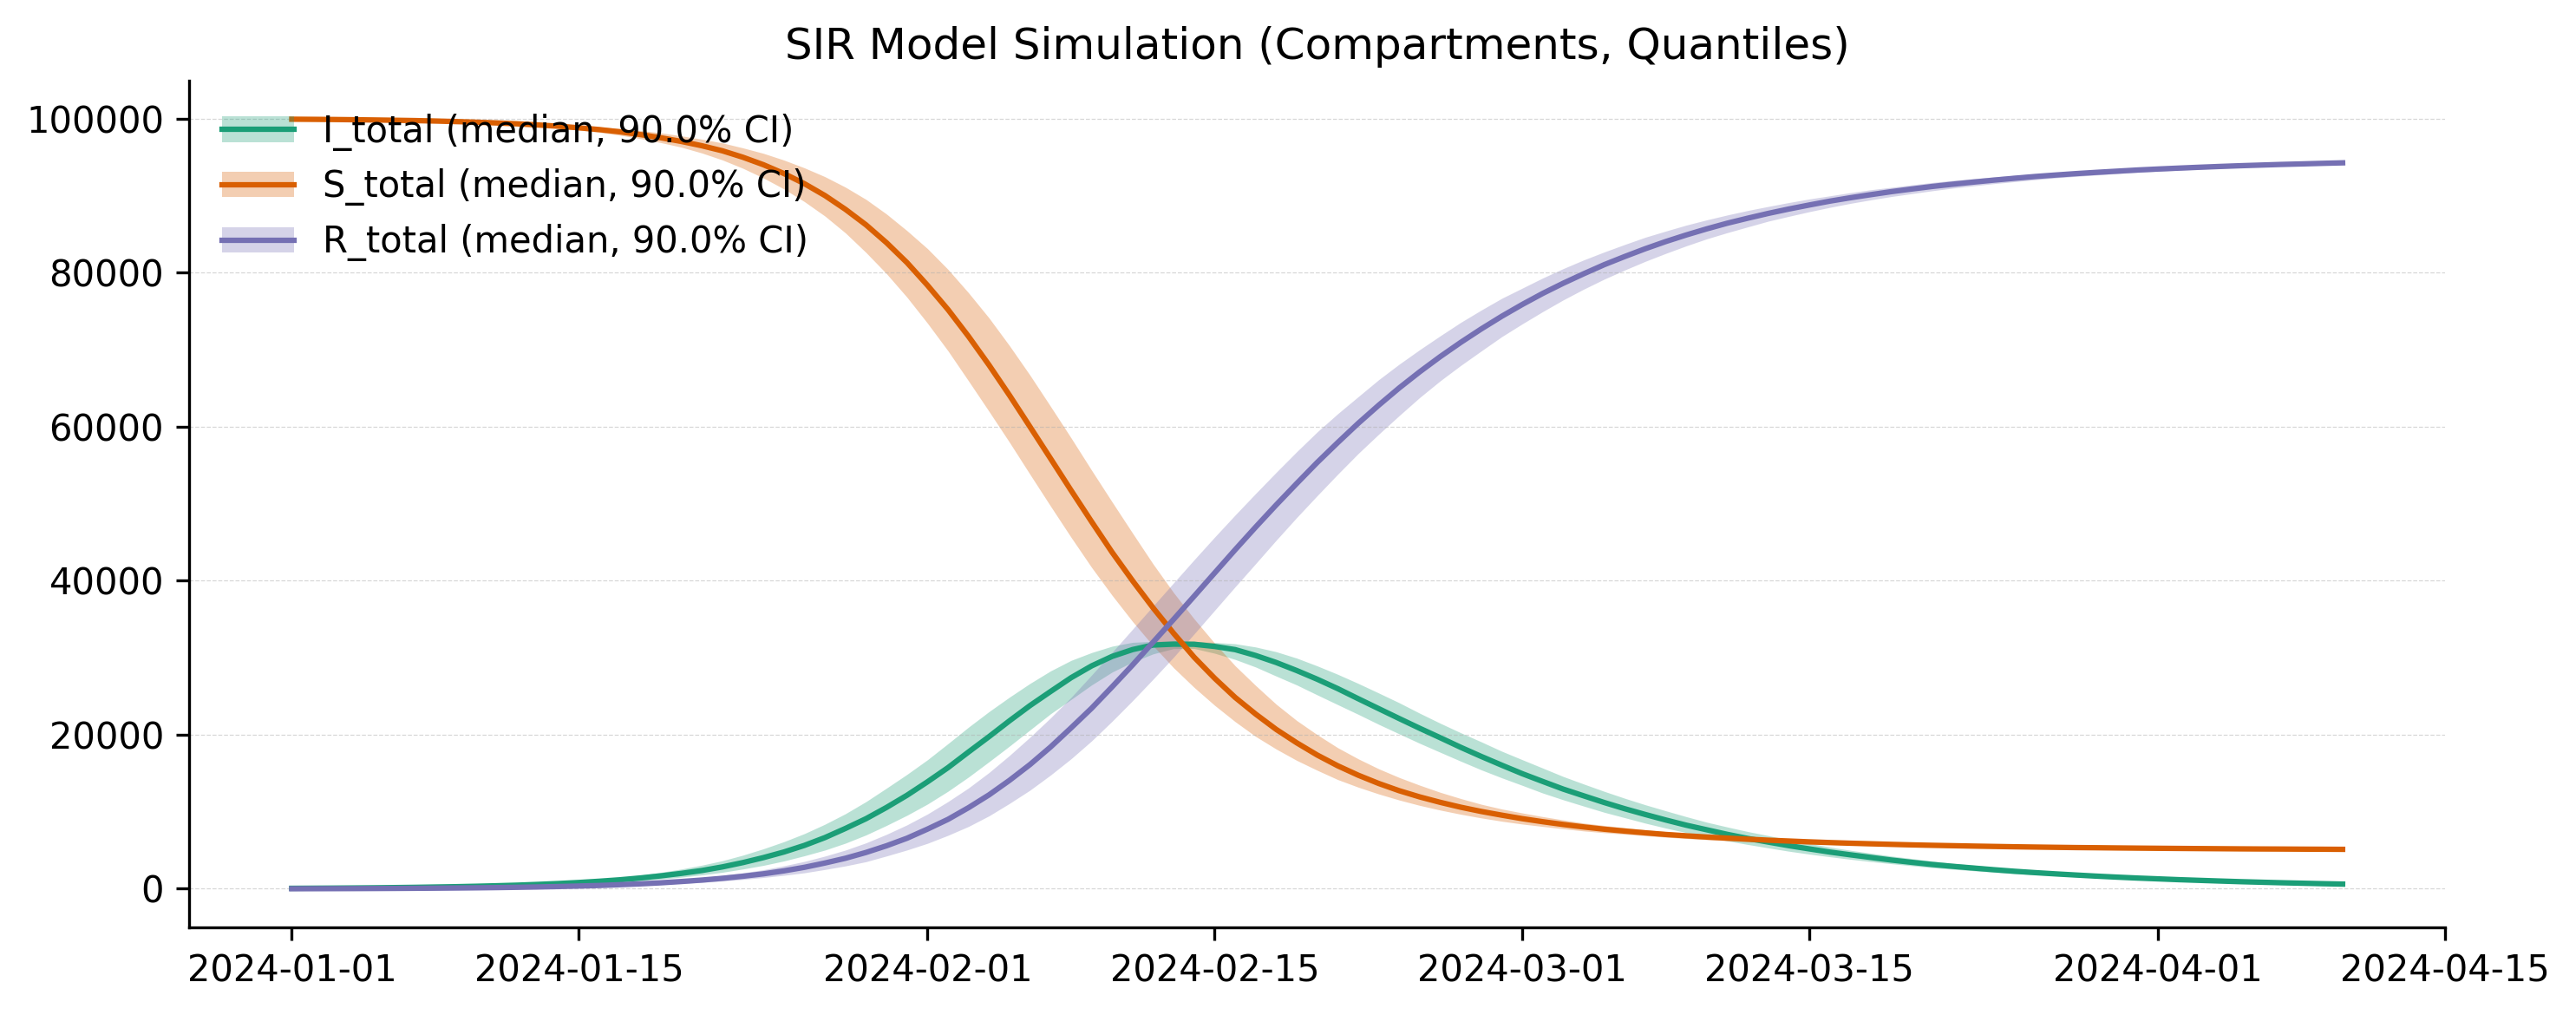

In [4]:
df_quantiles_comps = sir_results.get_quantiles_compartments()
ax = plot_quantiles(df_quantiles_comps, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation (Compartments, Quantiles)')

Similarly, we can plot the number of individuals transitioning between compartments. In this case, we will call the method `get_quantiles_transitions` to get the quantiles of the number of individuals transitioning between compartments over time. The name of the columns are the transitions names and the demographic groups, in the following format: `{source_compartment_name}_to_{target_compartment_name}_{demographic_group}`. 
For example, the column `S_to_I_total` contains the quantiles of the number of individuals transitioning from susceptible ("S") to infected ("I") individuals across all demographic groups ("total").

Let's create a plot to visualize the evolution of the transitions over time.

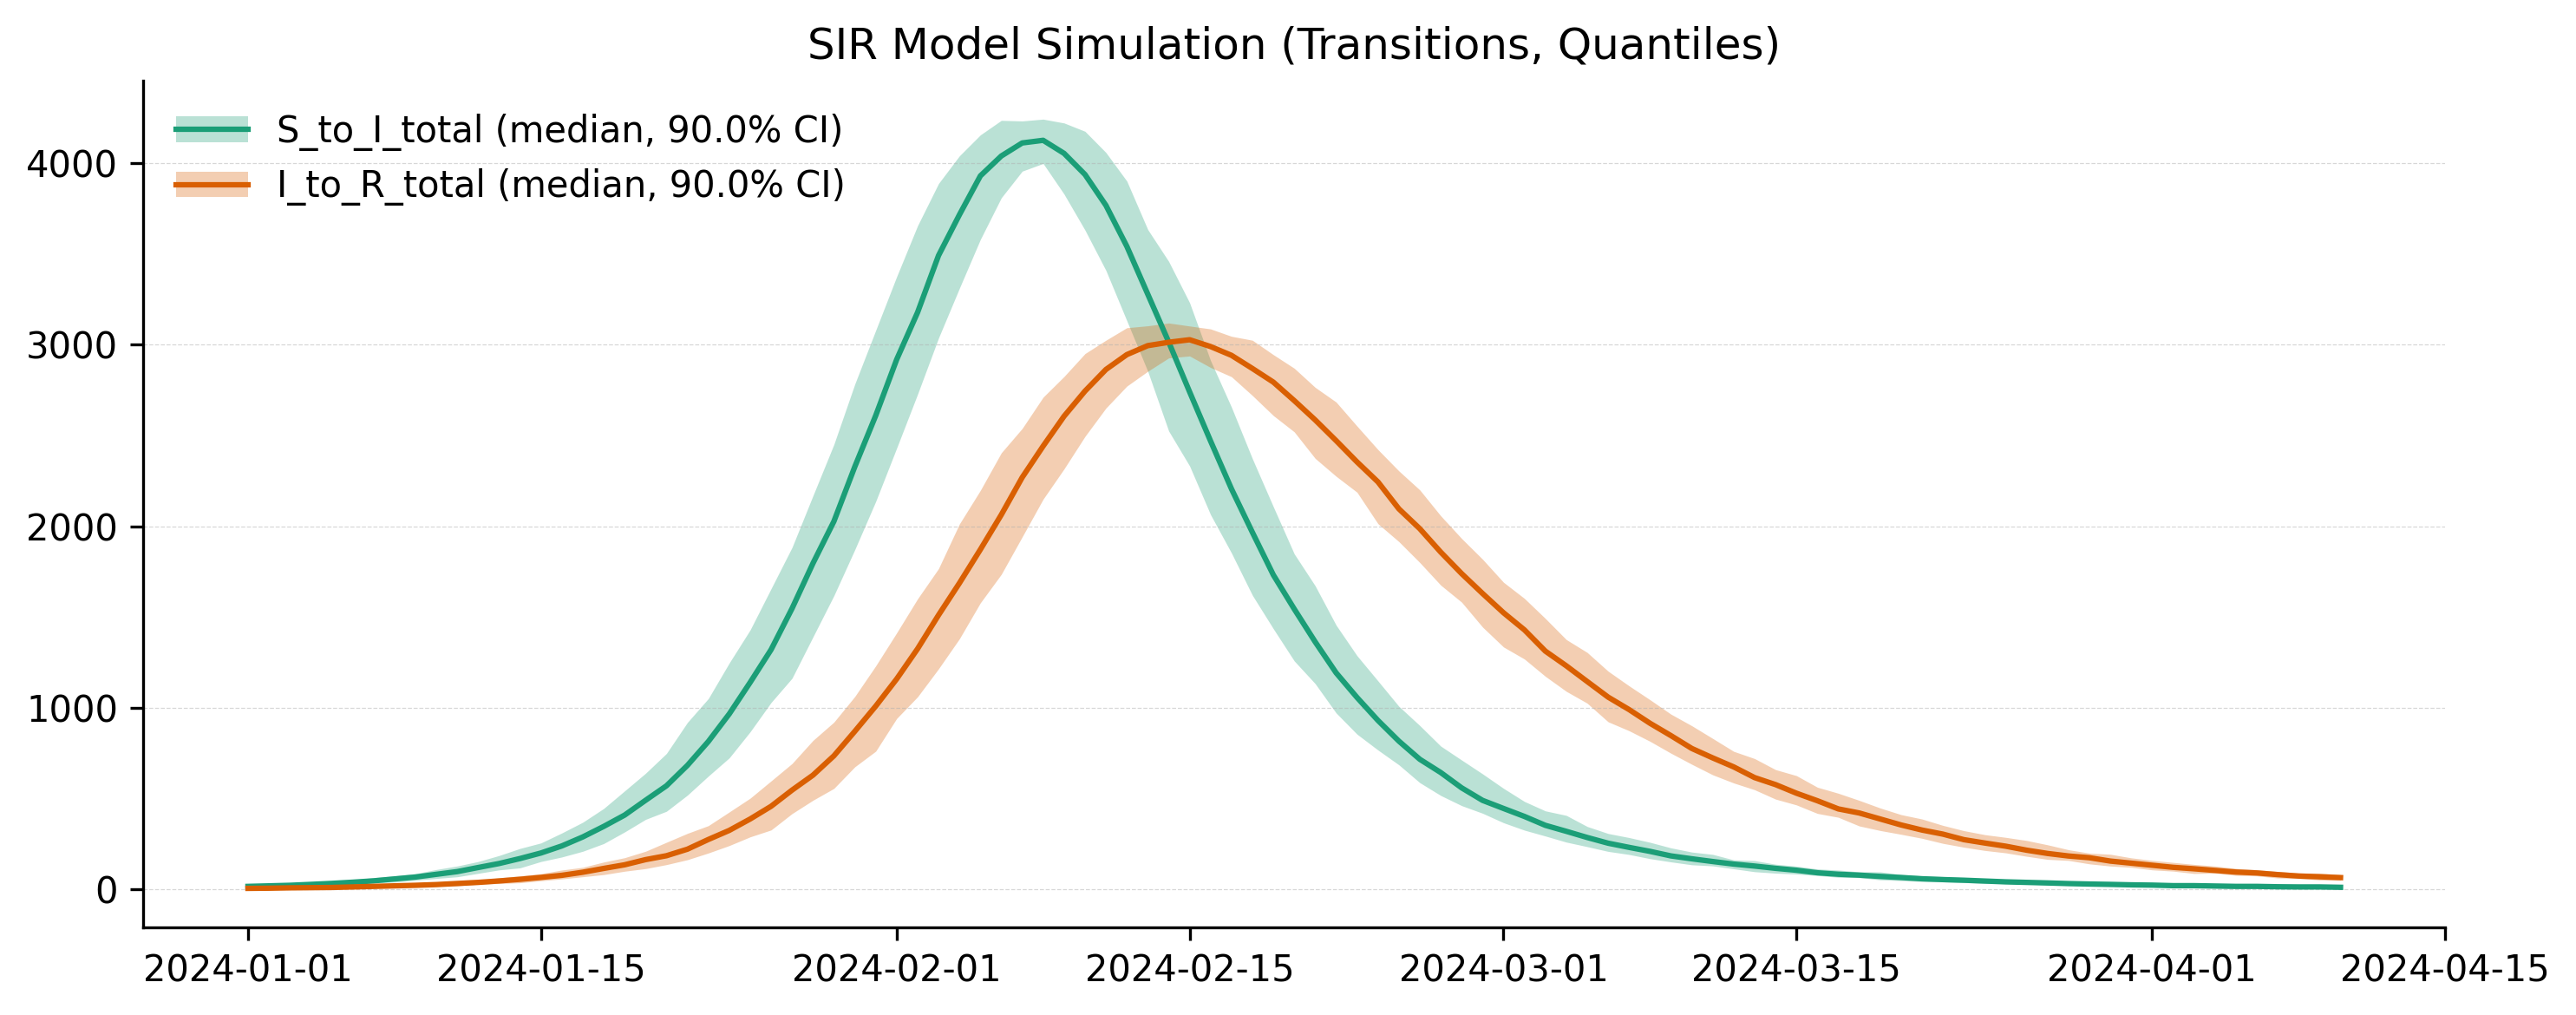

In [5]:
df_quantiles_tr = sir_results.get_quantiles_transitions()
ax = plot_quantiles(df_quantiles_tr, columns=["S_to_I_total", "I_to_R_total"], title='SIR Model Simulation (Transitions, Quantiles)')

Single stochastic simulation trajectories can be plotted as follows (with median highlighted):

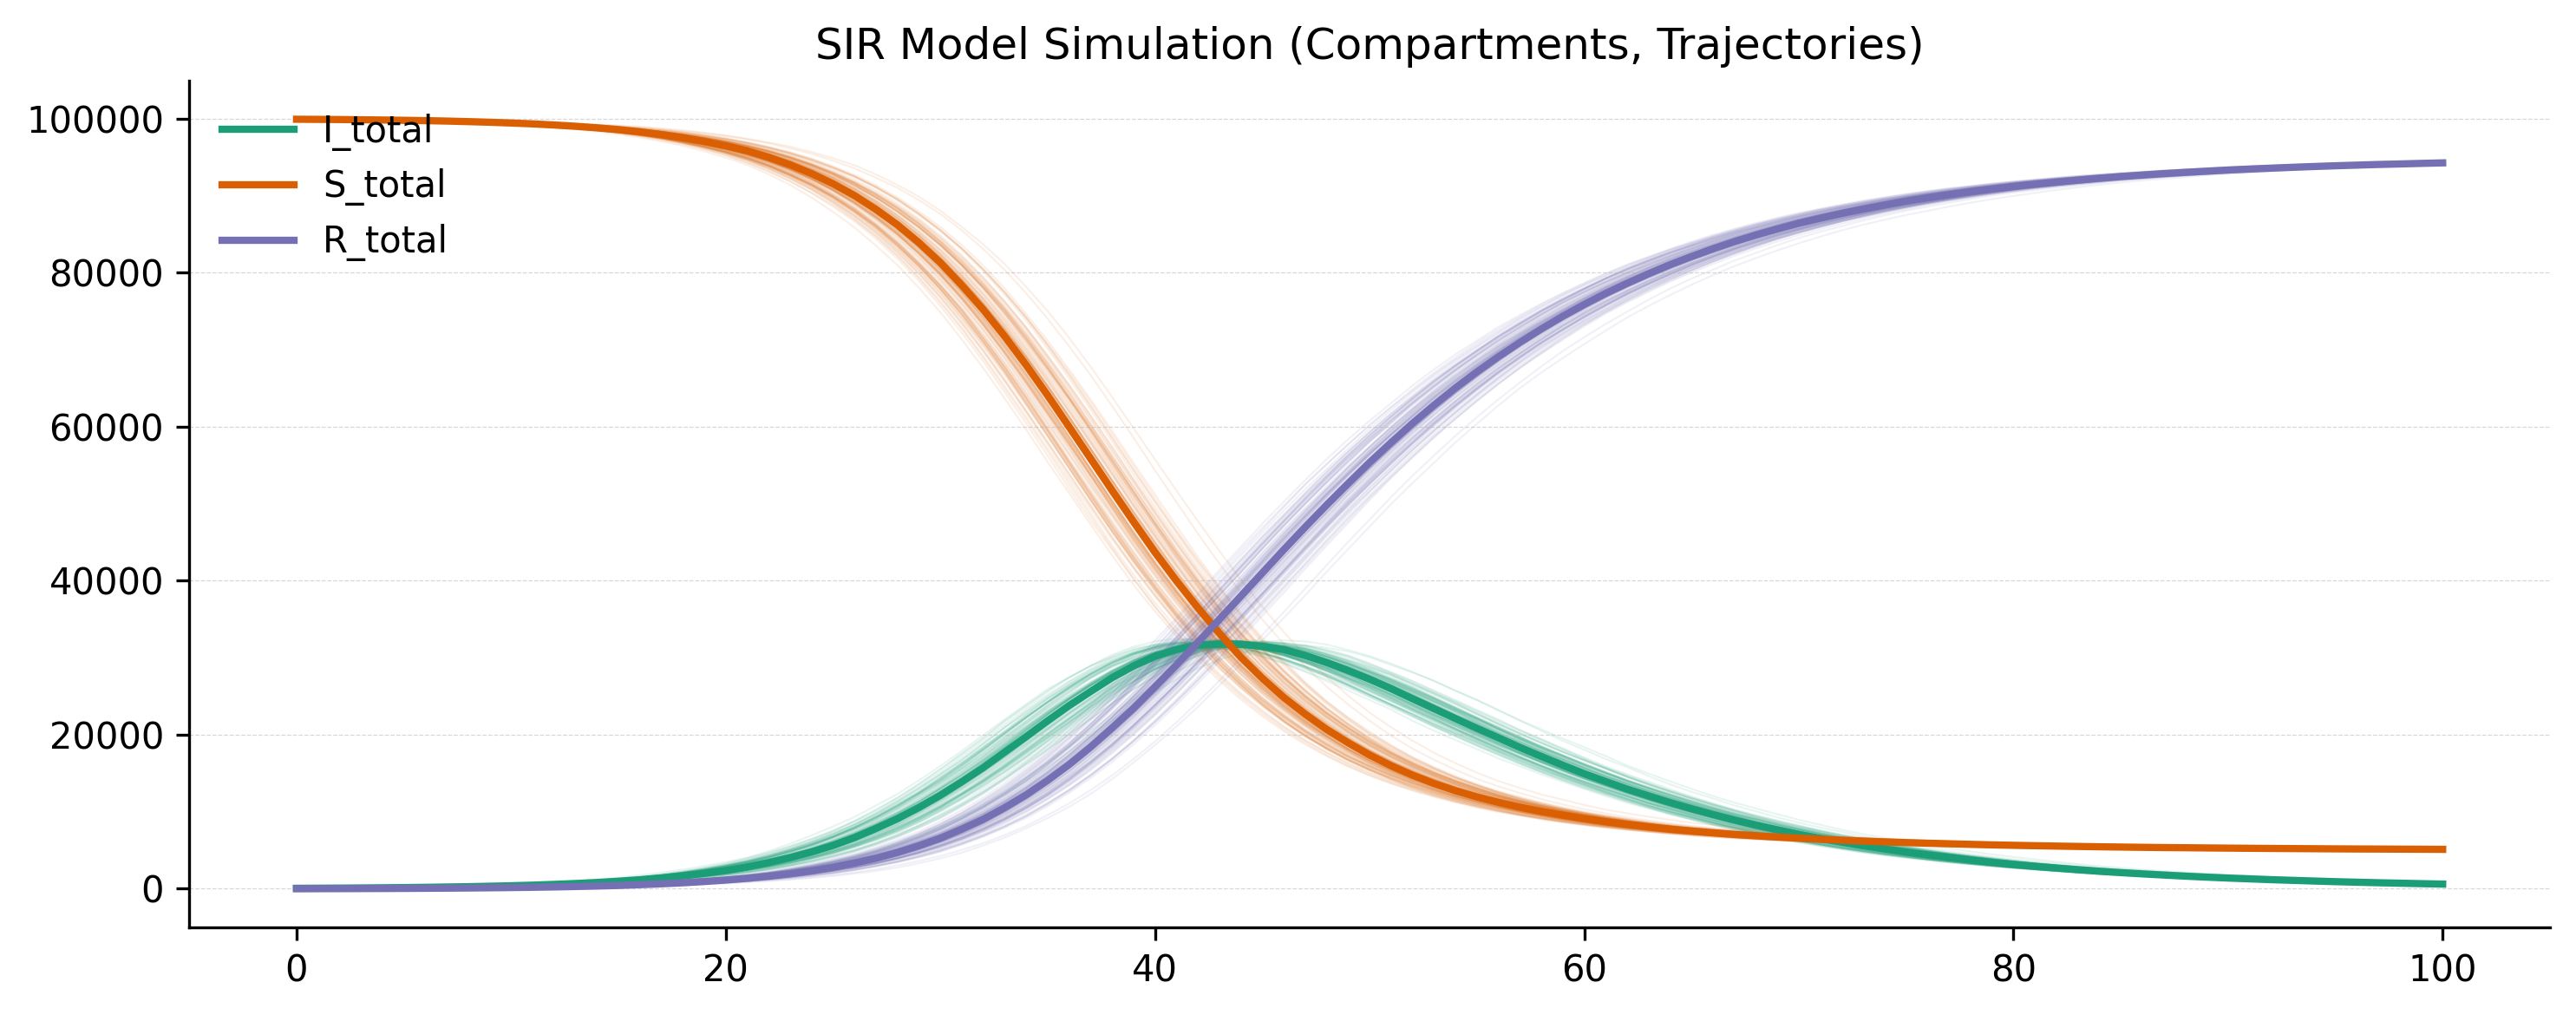

In [6]:
trajectories_comp = sir_results.get_stacked_compartments()
ax = plot_trajectories(trajectories_comp, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation (Compartments, Trajectories)')